### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

#Add the main folder to the path, so we have access to the files there.
#Note that if your working directory is not the Paper_code folder, you may need to manually specify the path to the main folder. For example: sys.path.append('/home/jglaser/GitProj/Neural_Decoding')
sys.path.append('..') 

from metrics import get_R2

### User Options

In [2]:
# load_folder='' #Folder where results are (for loading them)
load_folder='/home/jglaser/Files/Neural_Decoding/Results/'
# fig_folder='' #Folder to save the figures to
fig_folder='/home/jglaser/Figs/Decoding/' 
datasets=['m1','s1','hc'] #Names of the datasets
num_nrns_used=10 #Number of neurons used for decoding
ill=1 #Whether I am making these plots for exporting to adobe illustrator (in which case I remove the text)
colors=['purple','cyan','gold', 'red'] #Colors to plot each method

### Plot Summary (Fig. 6)

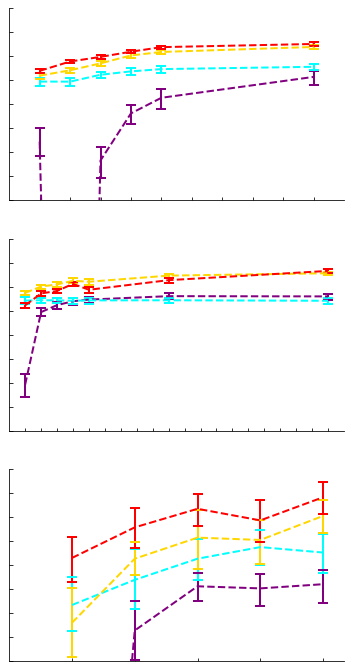

In [3]:
d=0 #Initialize index of the dataset I'm looking at (this will be the row I plot in the figure)
fig, ax = plt.subplots(3,1,figsize=(6,12)) #Create figure (3 rows by 1 column)


for dataset in datasets: #Loop through datasets

    ## LOAD RESULTS FOR ALL METHODS ##
    
    with open(load_folder+dataset+'_results_amt_wf.pickle','rb') as f:
            [mean_r2_wf,y_pred_wf_all]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_dnn.pickle','rb') as f:
            [mean_r2_dnn,y_pred_dnn_all,time_elapsed]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_lstm.pickle','rb') as f:
            [mean_r2_lstm,y_pred_lstm_all,time_elapsed]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_kf.pickle','rb') as f:
            [mean_r2_kf,y_pred_kf_all,y_valid_pred_kf_all,y_train_pred_kf_all,
                         y_kf_test_all,y_kf_valid_all,y_kf_train_all,lag]=pickle.load(f)        

    #Load test data
    with open(load_folder+dataset+'_ground_truth_amt.pickle','rb') as f:
        [y_test_all,y_train_all,y_valid_all]=pickle.load(f)    
    
    

    ##### BOOTSTRAP RESULTS #####

    num_splits=20 #How many sections to split the data up into
    num_bs=1000 #How many bootstrap iterations to do


    num_amts=len(y_test_all) #How many different training amounts were tested

    #Initialize matrices for bootstrap results
    #These matrices will contain the mean R2 value for each bootstrap, for each amount of training data
    mean_R2_bs_wf=np.empty([num_bs,num_amts])
    mean_R2_bs_kf=np.empty([num_bs,num_amts])
    mean_R2_bs_dnn=np.empty([num_bs,num_amts])
    mean_R2_bs_lstm=np.empty([num_bs,num_amts])



    for d_amt in range(num_amts): #Loop through amounts of training data
        
        #Determine how many data points are in each split
        num_test_examples=y_test_all[d_amt].shape[0]
        num_examples_per_split=np.round(np.divide(num_test_examples,num_splits))
        num_test_examples_kf=y_kf_test_all[d_amt].shape[0]
        num_examples_per_split_kf=np.round(np.divide(num_test_examples_kf,num_splits))

        #Get the predictions for all methods, for the current amount of training data (on this loop)
        y_pred_wf_temp=y_pred_wf_all[d_amt]
        y_pred_kf_temp=y_pred_kf_all[d_amt]
        y_pred_dnn_temp=y_pred_dnn_all[d_amt]
        y_pred_lstm_temp=y_pred_lstm_all[d_amt]
        #Get the actual results, for the current amount of training data (on this loop)
        y_test_temp=y_test_all[d_amt]
        y_test_temp_kf=y_kf_test_all[d_amt]

        #Create matrices used during bootstrapping
        #These matrices split up the data so that the data from each split is in a separate
        #I.e., they have size "num_splits" x "num_examples_per_split" x "num_outputs" instead of "num_examples" x "num_outputs"
        #That way we can easily resample from the first dimension (which splits to resample) during bootstrapping
        #We do this reformatting both for the predictions from all decoders, and the actual data
        
        #First we initialize these matrices
        y_test_bs=np.empty([num_splits,num_examples_per_split,y_test_all[0].shape[1]])
        y_preds_wf_bs=np.empty([num_splits,num_examples_per_split,y_test_all[0].shape[1]])
        y_preds_dnn_bs=np.empty([num_splits,num_examples_per_split,y_test_all[0].shape[1]])
        y_preds_lstm_bs=np.empty([num_splits,num_examples_per_split,y_test_all[0].shape[1]])
        #Same for KF
        y_test_kf_bs=np.empty([num_splits,num_examples_per_split_kf,y_test_all[0].shape[1]])
        y_preds_kf_bs=np.empty([num_splits,num_examples_per_split_kf,y_test_all[0].shape[1]])

        #Now we fill in these matrices by looping through sections (splits) and filling the data from that split into the matrix
        for i in range(num_splits): 
            idx=np.arange(num_examples_per_split*i,num_examples_per_split*(i+1)) #These are the indices of the data points from the given split
            y_test_bs[i,:,:]=y_test_temp[idx,:]    
            y_preds_wf_bs[i,:,:]=y_pred_wf_temp[idx,:]
            y_preds_dnn_bs[i,:,:]=y_pred_dnn_temp[idx,:]  
            y_preds_lstm_bs[i,:,:]=y_pred_lstm_temp[idx,:]          
            #Do the same for the KF example
            idx_kf=np.arange(num_examples_per_split_kf*i,num_examples_per_split_kf*(i+1))
            if dataset=='hc':
                y_test_kf_bs[i,:,:]=y_test_temp_kf[idx_kf,0:2]
            else:
                y_test_kf_bs[i,:,:]=y_test_temp_kf[idx_kf,2:4]    
            if dataset=='hc':
                y_preds_kf_bs[i,:,:]=y_pred_kf_temp[idx_kf,0:2]
            else:
                y_preds_kf_bs[i,:,:]=y_pred_kf_temp[idx_kf,2:4]


        ## BOOTSTRAP ##
        #In every bootstrap iteration, we:
        #1: Randomly select which splits to resample
        #2: Extract those datapoints from the matrices determined above and reshape them into the original 2D format
        #3: Calculate the R2 of that bootstrap
        
        for i in range(num_bs): #Loop through bootstrap iterations
            
            #Step 1
            random_idxs=np.floor(num_splits*np.random.rand(num_splits)).astype(int)
            
            #Step 2
            y_test=np.reshape(y_test_bs[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
            y_pred_wf=np.reshape(y_preds_wf_bs[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]]) 
            y_pred_dnn=np.reshape(y_preds_dnn_bs[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]]) 
            y_pred_lstm=np.reshape(y_preds_lstm_bs[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]]) 
            #For KF
            y_test_kf=np.reshape(y_test_kf_bs[random_idxs,:,:],[y_test_kf_bs.shape[0]*y_test_kf_bs.shape[1],y_test_kf_bs.shape[2]]) 
            y_pred_kf=np.reshape(y_preds_kf_bs[random_idxs,:,:],[y_test_kf_bs.shape[0]*y_test_kf_bs.shape[1],y_test_kf_bs.shape[2]]) 

            #Step 3
            mean_R2_bs_wf[i,d_amt]=np.mean(get_R2(y_test,y_pred_wf))
            mean_R2_bs_kf[i,d_amt]=np.mean(get_R2(y_test_kf,y_pred_kf))
            mean_R2_bs_dnn[i,d_amt]=np.mean(get_R2(y_test,y_pred_dnn))
            mean_R2_bs_lstm[i,d_amt]=np.mean(get_R2(y_test,y_pred_lstm))

      
            
    ### PLOT ###
    
    if dataset=='hc':
        x=[7.5, 15, 22.5, 30, 37.5] #Amounts of training data used

    if dataset=='s1':
        x=[1, 2, 3, 4, 5, 10, 20] #Amounts of training data used   

    if dataset=='m1':
        x=[1, 2, 3, 4, 5, 10] #Amounts of training data used

    #Extract confidence intervals for the bootstraps
    #I get the mean bootstrap value at the 16th, 50th, 84th percentile (to computer 68% CI, like an SEM)
    y_wf=np.percentile(mean_R2_bs_wf,[16,50,84],axis=0)
    y_kf=np.percentile(mean_R2_bs_kf,[16,50,84],axis=0)
    y_dnn=np.percentile(mean_R2_bs_dnn,[16,50,84],axis=0)
    y_lstm=np.percentile(mean_R2_bs_lstm,[16,50,84],axis=0)

    #Plot error bars for all methods
    wf_plot=ax[d].errorbar(x,y_wf[1],yerr=[y_wf[1]-y_wf[0],y_wf[2]-y_wf[1]],lw=2, capsize=5, capthick=2,fmt='--',color='purple')
    kf_plot=ax[d].errorbar(x,y_kf[1],yerr=[y_kf[1]-y_kf[0],y_kf[2]-y_kf[1]],lw=2, capsize=5, capthick=2,fmt='--',color='cyan')
    dnn_plot=ax[d].errorbar(x,y_dnn[1],yerr=[y_dnn[1]-y_dnn[0],y_dnn[2]-y_dnn[1]],lw=2, capsize=5, capthick=2,fmt='--',color='gold')
    lstm_plot=ax[d].errorbar(x,y_lstm[1],yerr=[y_lstm[1]-y_lstm[0],y_lstm[2]-y_lstm[1]],lw=2, capsize=5, capthick=2,fmt='--',color='red')

    
    #Plotting options
    ax[d].tick_params(direction='in')
    ax[d].spines['right'].set_color('none')
    ax[d].spines['top'].set_color('none')
    
    if dataset=='hc':
        ax[d].set_ylim([0, .8])
        ax[d].set_xlim([0,40])
        ax[d].set_xticks(np.arange(7.5,37.6,7.5))

    if dataset=='s1':
        ax[d].set_ylim([.2, 1])
        ax[d].set_xlim([0,21])
        ax[d].set_xticks(np.arange(1,20.1))

    if dataset=='m1':
        ax[d].set_ylim([.2, 1])
        ax[d].set_xlim([0,11])
        ax[d].set_xticks(np.arange(1,10.1))

    if ill:
        ax[d].set_xticklabels('')
        ax[d].set_yticklabels('')
    else:
        ax[d].set_xlabel('Minutes of Training Data')
        ax[d].set_ylabel('R^2')
    

    d=d+1  #Increase dataset index so the next dataset gets plot on the next row      

    
fig.savefig(fig_folder+'data_amt_summary.eps')   

## Plot Traces (Fig. 5)

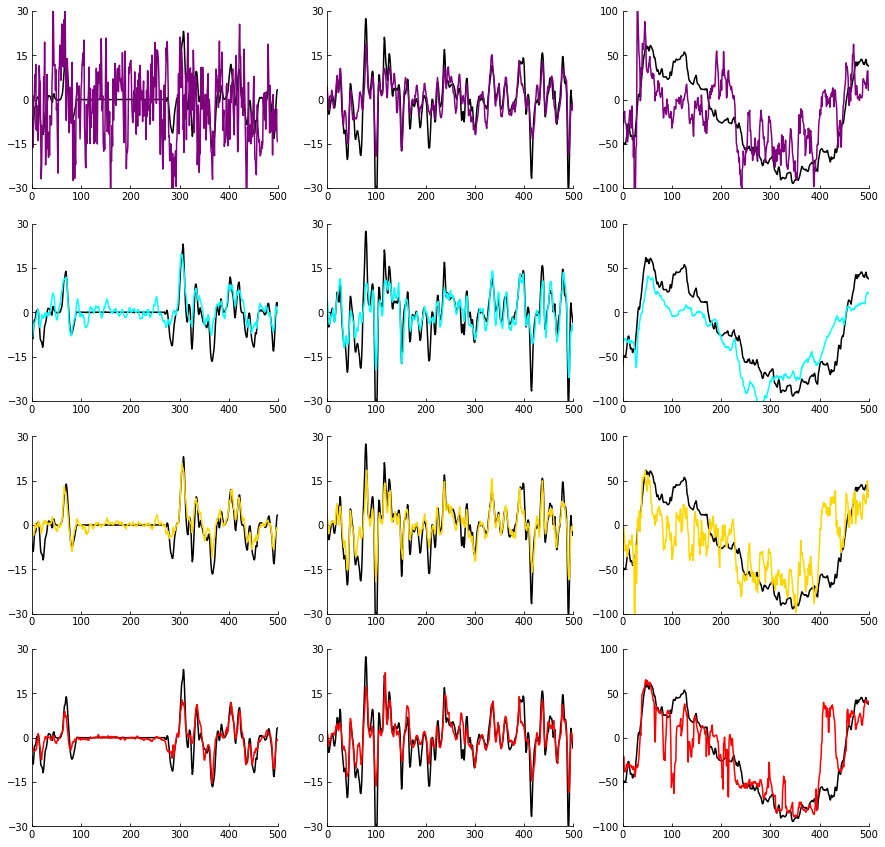

In [4]:
#Set times to plot
ts=np.arange(500,1000)

fig_traces, ax = plt.subplots(4,3,figsize=(15,15)) #Create figure (4 rows by 3 columns)

d=0 #Initialize index of the dataset I'm looking at (this will be the column I plot in the figure)

for dataset in datasets: #Loop through datasets

    ####LOAD RESULTS FOR ALL METHODS###
    
    with open(load_folder+dataset+'_results_amt_wf.pickle','rb') as f:
            [mean_r2_wf,y_pred_wf_all]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_dnn.pickle','rb') as f:
            [mean_r2_dnn,y_pred_dnn_all,time_elapsed]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_lstm.pickle','rb') as f:
            [mean_r2_lstm,y_pred_lstm_all,time_elapsed]=pickle.load(f)

    with open(load_folder+dataset+'_results_amt_kf.pickle','rb') as f:
            [mean_r2_kf,y_pred_kf_all,y_valid_pred_kf_all,y_train_pred_kf_all,
                         y_kf_test_all,y_kf_valid_all,y_kf_train_all,lag]=pickle.load(f) 

    #Load ground truth data (note that the ground truth data for KF was saved in that results file)    
    with open(load_folder+dataset+'_ground_truth_amt.pickle','rb') as f:
        [y_test_all,y_train_all,y_valid_all]=pickle.load(f)
    
    
    ### PLOT RESULTS ###
    #See "Plot_Results_FullData" file for commenting of below sections
    
    m=0 #Initialize method number. This corresponds to the row we're currently plotting in.
    
    #WF
    ax[m,d].plot(y_test_all[1][ts,0],'k')
    ax[m,d].plot(y_pred_wf_all[1][ts,0],colors[m])
    ax[m,d].tick_params(direction='in')
    if dataset=='hc':
        ax[m,d].set_ylim([-100,100])
        ax[m,d].set_yticks(np.arange(-100,100.1,50))
    else:
        ax[m,d].set_ylim([-30,30])
        ax[m,d].set_yticks(np.arange(-30,30.1,15))
    ax[m,d].set_xlim([0,500])
    ax[m,d].tick_params(direction='in')
    ax[m,d].spines['right'].set_color('none')
    ax[m,d].spines['top'].set_color('none')
    if ill:
        ax[m,d].set_xticklabels('')
        ax[m,d].set_yticklabels('')
    m=m+1

    #KF
    if dataset=='hc':
        ax[m,d].plot(y_kf_test_all[1][ts,0],'k')
        ax[m,d].plot(y_pred_kf_all[1][ts,0],colors[m])
    else:
        ax[m,d].plot(y_kf_test_all[1][ts,2],'k')
        ax[m,d].plot(y_pred_kf_all[1][ts,2],colors[m])
    ax[m,d].tick_params(direction='in')
    if dataset=='hc':
        ax[m,d].set_ylim([-100,100])
        ax[m,d].set_yticks(np.arange(-100,100.1,50))
    else:
        ax[m,d].set_ylim([-30,30])
        ax[m,d].set_yticks(np.arange(-30,30.1,15))
    ax[m,d].set_xlim([0,500])
    ax[m,d].tick_params(direction='in')
    ax[m,d].spines['right'].set_color('none')
    ax[m,d].spines['top'].set_color('none')
    if ill:
        ax[m,d].set_xticklabels('')
        ax[m,d].set_yticklabels('')
    m=m+1
    
    #DNN
    ax[m,d].plot(y_test_all[1][ts,0],'k')
    ax[m,d].plot(y_pred_dnn_all[1][ts,0],colors[m])
    ax[m,d].tick_params(direction='in')
    if dataset=='hc':
        ax[m,d].set_ylim([-100,100])
        ax[m,d].set_yticks(np.arange(-100,100.1,50))
    else:
        ax[m,d].set_ylim([-30,30])
        ax[m,d].set_yticks(np.arange(-30,30.1,15))
    ax[m,d].set_xlim([0,500])
    ax[m,d].tick_params(direction='in')
    ax[m,d].spines['right'].set_color('none')
    ax[m,d].spines['top'].set_color('none')
    if ill:
        ax[m,d].set_xticklabels('')
        ax[m,d].set_yticklabels('')
    m=m+1
    
    #LSTM
    ax[m,d].plot(y_test_all[1][ts,0],'k')
    ax[m,d].plot(y_pred_lstm_all[1][ts,0],colors[m])
    ax[m,d].tick_params(direction='in')
    if dataset=='hc':
        ax[m,d].set_ylim([-100,100])
        ax[m,d].set_yticks(np.arange(-100,100.1,50))
    else:
        ax[m,d].set_ylim([-30,30])
        ax[m,d].set_yticks(np.arange(-30,30.1,15))
    ax[m,d].set_xlim([0,500])
    ax[m,d].tick_params(direction='in')
    ax[m,d].spines['right'].set_color('none')
    ax[m,d].spines['top'].set_color('none')
    if ill:
        ax[m,d].set_xticklabels('')
        ax[m,d].set_yticklabels('')
    
    m=m+1 #Increase method index (next row)
        
    d=d+1 #Increase dataset index (next column)

    
fig_traces.savefig(fig_folder+'data_amt_traces.eps') 